In [3]:
import xlrd
import graphviz
import pydot
import pydotplus
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from keras import layers
import tensorflow as tf
import random
from sklearn.model_selection import KFold
from keras.callbacks import ReduceLROnPlateau

# Preparation

In [348]:
# Read data
data = pd.read_csv('Data_model_citation_counts.csv')
# Display Data
data

,times_cited,com1,com2,com3,com4,com5,com6,com7,com8,com9,...,avg_cocitation_degree,max_cocitation_degree,avg_cocitation_pagerank,max_cocitation_pagerank,avg_cocitation_closeness,max_cocitation_closeness,avg_cocitation_betweenness,max_cocitation_betweenness,avg_cocitation_eigenvector,max_cocitation_eigenvector
0,2,0,0,0,0,0,0,1,0,0,...,-0.812305,-0.844063,-0.700841,-0.678452,-1.645109,-0.828659,-0.366730,-0.349845,-0.752988,-0.828408
1,1,0,0,0,0,0,0,0,0,0,...,-0.812606,-0.844451,-0.490453,-0.569488,-2.726319,-3.024031,-0.366730,-0.349845,-0.753003,-0.828430
2,48,0,0,0,0,0,0,0,0,0,...,-0.812606,-0.844451,-0.717578,-0.697287,-2.726319,-3.024031,-0.366730,-0.349845,-0.753003,-0.828430
3,24,0,0,0,0,0,0,0,0,0,...,-0.628536,-0.532096,-0.535448,-0.430261,0.102117,0.249852,-0.351946,-0.328593,-0.619343,-0.568847
4,3,0,0,0,0,0,0,1,0,0,...,-0.686576,-0.710584,-0.570225,-0.553282,0.195121,0.120344,-0.356354,-0.340922,-0.685004,-0.745566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55019,33,0,0,0,0,0,0,0,0,0,...,2.051715,0.998639,5.059372,2.553292,0.923501,0.681408,10.533310,4.579372,0.638905,0.146249
55020,64,0,0,0,0,0,0,0,0,0,...,1.228599,0.468993,1.592733,0.602681,0.824773,0.581175,2.374633,0.889854,0.476812,0.032744
55021,32,0,0,0,1,0,0,0,0,0,...,-0.362556,-0.302388,-0.286997,-0.264262,0.446099,0.367708,-0.179878,-0.181007,-0.416045,-0.360568
55022,10,0,0,0,0,0,1,0,0,0,...,-0.405571,-0.320625,-0.540804,-0.498352,-1.074596,0.329756,-0.346609,-0.331647,-0.447493,-0.400565


In [349]:
data = np.array(data)

In [302]:
# 10-fold cross-validation
# Set division
kf = 10   # 10-fold
p = 78    # p-dimension
KF = KFold(n_splits = kf, shuffle = True, random_state = 7)

# Determine the number of layers and neurons

First, build a neural network model with only one hidden layer and set the initial number of neurons from 10 to 190 (increase 20 for each time). For each initial number, we train the model via the 10-fold cross-validation (CV). Further, the mean absolute error (MAE) of each validation set is reported and the average of the MAE is named the 10-fold CV MAE. The number of neurons corresponding to the minimum MAE is selected as the optimal number in this hidden layer. Second, fix the number of neurons in the previous hidden layer and add a new hidden layer. The optimal number of neurons in the newly added layer is determined by repeating the first step. Third, add model layers up to 4. 

## One hidden layer

In [ ]:
# Construct neural network model
# Record MAE
MAE = np.zeros([kf*10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    for initial_num in range(10,210,20):
        # Define Sequential model with 1 hidden layers
        model_one_layers = keras.Sequential([
            layers.Dense(77, activation = "relu", name = "input", input_dim = 77),
            layers.Dense(initial_num, activation = "relu", name = "layer1"),
            layers.Dense(1, name = "output")])
        # ReduceLROnPlateau
        reduce_lr = ReduceLROnPlateau(monitor = 'mae', 
                    factor = 0.5, # Divide the learning rate by 2 when triggered
                    patience = 3, # If the verification loss does not improve within 3 rounds, then trigger this callback function
                    verbose = 1)
        # Optimizer for Adam
        optimizer = keras.optimizers.Adam(learning_rate = 0.01)
        model_one_layers.compile(optimizer = optimizer,
                    loss = 'mae',
                    metrics = ['mae'])
        # Train the model
        history = model_one_layers.fit(train_X, train_Y, epochs = 200, verbose = 1, callbacks = [reduce_lr])
        # Prediction
        test_predictions = model_one_layers.predict(test_X)
        # MAE
        model_error = abs((test_predictions.ravel() - test_Y))
        MAE[i] = model_error.mean()
        i = i + 1
# Save result
MAE = pd.DataFrame(list(MAE))
MAE.to_csv("MAE_first_layer.csv", sep = ",", index = False)

## Two hidden layers

In [ ]:
# Construct neural network model
# Record MAE
MAE = np.zeros([kf*10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    for initial_num in range(10,210,20):
        # Define Sequential model with 2 hidden layers
        model_one_layers = keras.Sequential([
            layers.Dense(77, activation = "relu", name = "input", input_dim = 77),
            layers.Dense(150, activation = "relu", name = "layer1"),
            layers.Dense(initial_num, activation = "relu", name = "layer2"),
            layers.Dense(1, name = "output")])
        # ReduceLROnPlateau
        reduce_lr = ReduceLROnPlateau(monitor = 'mae', 
                    factor = 0.5, # Divide the learning rate by 2 when triggered
                    patience = 3, # If the verification loss does not improve within 3 rounds, then trigger this callback function
                    verbose = 1)
        # Optimizer for Adam
        optimizer = keras.optimizers.Adam(learning_rate = 0.01)
        model_one_layers.compile(optimizer = optimizer,
                    loss = 'mae',
                    metrics = ['mae'])
        # Train the model
        history = model_one_layers.fit(train_X, train_Y, epochs = 200, verbose = 1, callbacks = [reduce_lr])
        # Prediction
        test_predictions = model_one_layers.predict(test_X)
        # MAE
        model_error = abs((test_predictions.ravel() - test_Y))
        MAE[i] = model_error.mean()
        i = i + 1
# Save result
MAE = pd.DataFrame(list(MAE))
MAE.to_csv("MAE_second_layer.csv",sep = ",", index = False)

## Three hidden layers

In [ ]:
# Construct neural network model
# Record MAE
MAE = np.zeros([kf*10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    for initial_num in range(10,210,20):
        # Define Sequential model with 3 hidden layers
        model_one_layers = keras.Sequential([
            layers.Dense(77, activation = "relu", name = "input", input_dim = 77),
            layers.Dense(150, activation = "relu", name = "layer1"),
            layers.Dense(130, activation = "relu", name = "layer2"),
            layers.Dense(initial_num, activation = "relu", name = "layer3"),
            layers.Dense(1, name = "output")])
        # ReduceLROnPlateau
        reduce_lr = ReduceLROnPlateau(monitor = 'mae', 
                    factor = 0.5, # Divide the learning rate by 2 when triggered
                    patience = 3, # If the verification loss does not improve within 3 rounds, then trigger this callback function
                    verbose = 1)
        # Optimizer for Adam
        optimizer = keras.optimizers.Adam(learning_rate = 0.01)
        model_one_layers.compile(optimizer = optimizer,
                    loss = 'mae',
                    metrics = ['mae'])
        # Train the model
        history = model_one_layers.fit(train_X, train_Y, epochs = 200, verbose = 1, callbacks = [reduce_lr])
        # Prediction
        test_predictions = model_one_layers.predict(test_X)
        # MAE
        model_error = abs((test_predictions.ravel() - test_Y))
        MAE[i] = model_error.mean()
        i = i + 1
# Save result
MAE = pd.DataFrame(list(MAE))
MAE.to_csv("MAE_third_layer.csv", sep = ",", index = False)

## Four hidden layers

In [ ]:
# Construct neural network model
# Record MAE
MAE = np.zeros([kf*10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    for initial_num in range(10,210,20):
        # Define Sequential model with 4 hidden layers
        model_one_layers = keras.Sequential([
            layers.Dense(77, activation = "relu", name = "input", input_dim = 77),
            layers.Dense(150, activation = "relu", name = "layer1"),
            layers.Dense(130, activation = "relu", name = "layer2"),
            layers.Dense(10, activation = "relu", name = "layer3"),
            layers.Dense(initial_num, activation = "relu", name = "layer4"),
            layers.Dense(1, name = "output")])
        # ReduceLROnPlateau
        reduce_lr = ReduceLROnPlateau(monitor = 'mae', 
                    factor = 0.5, # Divide the learning rate by 2 when triggered
                    patience = 3, # If the verification loss does not improve within 3 rounds, then trigger this callback function
                    verbose = 1)
        # Optimizer for Adam
        optimizer = keras.optimizers.Adam(learning_rate = 0.01)
        model_one_layers.compile(optimizer = optimizer,
                    loss = 'mae',
                    metrics = ['mae'])
        # Train the model
        history = model_one_layers.fit(train_X, train_Y, epochs = 200, verbose = 1, callbacks = [reduce_lr])
        # Prediction
        test_predictions = model_one_layers.predict(test_X)
        # MAE
        model_error = abs((test_predictions.ravel() - test_Y))
        MAE[i] = model_error.mean()
        i = i + 1
# Save result
MAE = pd.DataFrame(list(MAE))
MAE.to_csv("MAE_forth_layer.csv", sep = ",", index = False)

## The 10-fold CV MAE of the neural network model

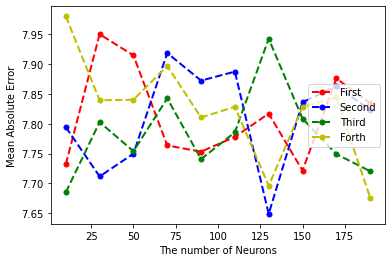

In [243]:
MAE_first = pd.read_csv("MAE_first_layer.csv")
MAE_first_result = pd.DataFrame(np.mat(np.array(MAE_first).reshape(10,10)))
MAE_second = pd.read_csv("MAE_second_layer.csv")
MAE_second_result = pd.DataFrame(np.mat(np.array(MAE_second).reshape(10,10)))
MAE_third = pd.read_csv("MAE_third_layer.csv")
MAE_third_result = pd.DataFrame(np.mat(np.array(MAE_third).reshape(10,10)))
MAE_forth = pd.read_csv("MAE_forth_layer.csv")
MAE_forth_result = pd.DataFrame(np.mat(np.array(MAE_forth).reshape(10,10)))
plt.plot(range(10,210,20), MAE_first_result.mean(),  c = 'r', lw = '2', ls = '--', marker = 'o', ms = 5, label = 'First')
plt.plot(range(10,210,20), MAE_second_result.mean(), c = 'b', lw = '2', ls = '--', marker = 'o', ms = 5, label = 'Second')
plt.plot(range(10,210,20), MAE_third_result.mean(),  c = 'g', lw = '2', ls = '--', marker = 'o', ms = 5, label = 'Third')
plt.plot(range(10,210,20), MAE_forth_result.mean(),  c = 'y', lw = '2', ls = '--', marker = 'o', ms = 5, label = 'Forth')
plt.legend(loc='center right') # Legend
plt.xlabel('The number of Neurons', fontsize = 10)
plt.ylabel('Mean Absolute Error', fontsize = 10)
plt.show()

# Final Model

The two hidden layers have 150 and 130 neurons respectively

In [ ]:
# Construct neural network model
kf = 10
p = 78
KF = KFold(n_splits = kf,shuffle=True,random_state=7)
MAE = np.zeros([kf])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Define Sequential model with 2 hidden layers
    model_one_layers = keras.Sequential([
        layers.Dense(77, activation = "relu", name = "input", input_dim = 77),
        layers.Dense(150, activation = "relu", name = "layer1"),
        layers.Dense(130, activation = "relu", name = "layer2"),
        layers.Dense(1, name = "output")])
    # ReduceLROnPlateau
    reduce_lr = ReduceLROnPlateau(monitor = 'mae', 
                factor = 0.5, # Divide the learning rate by 2 when triggered
                patience = 3, # If the verification loss does not improve within 3 rounds, then trigger this callback function
                verbose = 1)
    # Optimizer for Adam
    optimizer = keras.optimizers.Adam(learning_rate = 0.01)
    model_one_layers.compile(optimizer = optimizer,
                    loss = 'mae',
                    metrics = ['mae'])
    # Train the model
    history = model_one_layers.fit(train_X, train_Y, epochs = 200, verbose = 1, callbacks = [reduce_lr])
    # Prediction
    test_predictions = model_one_layers.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel() - test_Y))
    MAE[i] = model_error.mean()
    i = i + 1
# Save result
MAE = pd.DataFrame(list(MAE))
MAE.to_csv("MAE_final_model.csv", sep = ",", index = False)

In [245]:
# The structure of model
model_one_layers.summary()

Model: "sequential_1787"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 77)                6006      
_________________________________________________________________
layer2 (Dense)               (None, 150)               11700     
_________________________________________________________________
layer3 (Dense)               (None, 130)               19630     
_________________________________________________________________
layer4 (Dense)               (None, 1)                 131       
Total params: 37,467
Trainable params: 37,467
Non-trainable params: 0
_________________________________________________________________


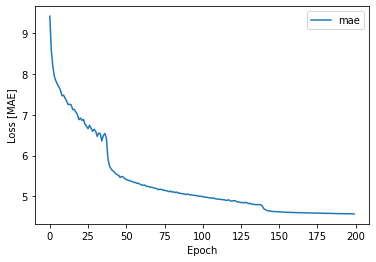

In [246]:
# Loss
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss [MAE]')
plt.plot(hist['epoch'], hist['mae'],label='mae')
plt.legend()
plt.show()

# The Importance of Factors

The leave-one-feature-out method is adopted to measure the importance of factors \citep{li2022predicting}. First, we regard the model with all factors as the basic model. Second, we train the model by leaving one feature out and record the 10-fold CV MAE. Third, the absolute difference of the 10-fold CV MAE between the leave-one-feature-out model and the basic model is calculated. Finally, we normalize the absolute difference and transform it into a value between 0-100. The larger the value, the more important the factor is. 

In [ ]:
# Construct neural network model
kf = 10
MAE = np.zeros([kf*77])
i = 0
KF = KFold(n_splits = kf, shuffle=True, random_state=7)
for p in range(1,78):
    print(p)
    for train_index,test_index in KF.split(data):
        train_X = data[train_index, :]
        train_X = train_X[:, [_ for _ in range(1,78) if _ != p]]
        train_Y = data[train_index, 0]
        test_X = data[test_index, :]
        test_X = test_X[:, [_ for _ in range(1,78) if _ != p]]
        test_Y = data[test_index, 0]
        # Define Sequential model with 2 hidden layers
        model_one_layers = keras.Sequential([
            layers.Dense(76, activation = "relu", name = "input", input_dim = 76),
            layers.Dense(150, activation = "relu", name = "layer1"),
            layers.Dense(130, activation = "relu", name = "layer2"),
            layers.Dense(1, name = "output")])
        # ReduceLROnPlateau
        reduce_lr = ReduceLROnPlateau(monitor = 'mae', 
                    factor = 0.5, # Divide the learning rate by 2 when triggered
                    patience = 3, # If the verification loss does not improve within 3 rounds, then trigger this callback function
                    verbose = 1)
        # Optimizer for Adam
        optimizer = keras.optimizers.Adam(learning_rate = 0.01)
        model_one_layers.compile(optimizer = optimizer,
                    loss = 'mae',
                    metrics = ['mae'])
        # Train the model
        history = model_one_layers.fit(train_X, train_Y, epochs = 200, verbose = 1, callbacks = [reduce_lr])
        # Prediction
        test_predictions = model_one_layers.predict(test_X)
        # MAE
        model_error = abs((test_predictions.ravel()-test_Y))
        MAE[i] = model_error.mean()
        i = i + 1
# 保存结果
MAE_leave_one_feature_out = pd.DataFrame(list(MAE))
MAE_leave_one_feature_out.to_csv("MAE_Leave_one_feature_out.csv", sep = ",", index = False)

# Comparison with other methods
## 9 commonly used methods
we select 9 commonly used methods to compare with our model, including XGBoost, gradient boosting, support vector regression, random forest, LightGBM, $k$-nearest neighbor regression, LASSO, elastic net and linear regression. For each method, we report the MAE on each validation set generated by 10-fold CV.

In [286]:
# Model
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import time as time

### SVR

In [ ]:
score_SVR = np.zeros([10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Train the model
    svr = make_pipeline( SVR(kernel='linear')).fit(train_X, train_Y)
    # Prediction
    test_predictions = svr.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel()-test_Y))
    score_SVR[i] = model_error.mean()
    i = i + 1

### LR

In [ ]:
score_LR = np.zeros([10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Train the model
    LR = make_pipeline(LinearRegression()).fit(train_X, train_Y)
    # Prediction
    test_predictions = LR.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel()-test_Y))
    score_LR[i] = model_error.mean()
    i = i + 1

### XGBoost

In [ ]:
score_Xgboost = np.zeros([10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Train the model
    model_xgb = xgb.XGBRegressor(booster='gbtree',colsample_bytree=0.8, gamma = 0,
                             learning_rate=0.1, max_depth=5,
                             n_estimators=500,min_child_weight=1,
                             reg_alpha=0, reg_lambda=1,
                             subsample=0.8,
                             random_state =42).fit(train_X, train_Y)
    # Prediction
    test_predictions = model_xgb.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel()-test_Y))
    score_Xgboost[i] = model_error.mean()
    i = i + 1

### LASSO

In [346]:
score_LASSO = np.zeros([10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Train the model
    lasso = make_pipeline( Lasso(alpha =0.0005, random_state=1,max_iter=10000000, positive=True)).fit(train_X, train_Y)
    # Prediction
    test_predictions = lasso.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel()-test_Y))
    score_LASSO[i] = model_error.mean()
    i = i + 1

### Elastic Net

In [ ]:
score_ElasticNet = np.zeros([10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Train the model
    ENet = make_pipeline(ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3,max_iter=10000000)).fit(train_X, train_Y)
    # Prediction
    test_predictions = ENet.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel()-test_Y))
    score_ElasticNet[i] = model_error.mean()
    i = i + 1

### Gradient Boosting

In [ ]:
score_GB = np.zeros([10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Train the model
    GBoost = GradientBoostingRegressor(n_estimators=500, learning_rate=0.02,
                                    max_depth=5, max_features=7,
                                    min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =5).fit(train_X, train_Y)
    # Prediction
    test_predictions = GBoost.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel()-test_Y))
    score_GB[i] = model_error.mean()
    i = i + 1

### LGBM

In [337]:
score_LGBM = np.zeros([10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Train the model
    model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                               learning_rate=0.05, n_estimators=500).fit(train_X, train_Y)
    # Prediction
    test_predictions = model_lgb.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel()-test_Y))
    score_LGBM[i] = model_error.mean()
    i = i + 1

### Random Forest

In [336]:
score_RF = np.zeros([10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Train the model
    rf = RandomForestRegressor(n_estimators= 50, max_depth=25, min_samples_split=20,
                               min_samples_leaf=10,max_features='sqrt' ,oob_score=True, 
                               random_state=10).fit(train_X, train_Y)
    # Prediction
    test_predictions = rf.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel()-test_Y))
    score_RF[i] = model_error.mean()
    i = i + 1

### KNN

In [334]:
score_KNN = np.zeros([10])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Train the model
    knn = KNeighborsRegressor(n_neighbors=3).fit(train_X, train_Y)
    # Prediction
    test_predictions = knn.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel()-test_Y))
    score_KNN[i] = model_error.mean()
    i = i + 1

In [347]:
# Save result
result = pd.DataFrame(list(zip(score_SVR, score_LASSO, score_ElasticNet, score_GB, score_Xgboost, score_LGBM, score_RF, score_KNN, score_LR)))
result.columns = ['score_SVR','score_LASSO','score_ElasticNet','score_GB','score_Xgboost','score_LGBM','score_RF','score_KNN','score_LR'] 
result.to_csv("Citation_count_pre_result.csv", sep = ",", index = False)
result

,score_SVR,score_LASSO,score_ElasticNet,score_GB,score_Xgboost,score_LGBM,score_RF,score_KNN,score_LR
0,8.060508,11.376153,11.611226,7.881905,7.827563,9.344578,8.839938,10.990551,11.626615
1,9.977483,12.349789,12.610718,9.784419,8.897829,10.450583,10.411239,12.060694,12.625850
2,9.022834,12.112551,12.186845,8.449269,8.518780,9.883509,9.607925,11.384094,12.194539
3,8.957908,12.269644,12.466566,8.433555,8.744953,9.851523,9.585174,11.186625,12.481218
4,9.466605,12.401840,12.751434,9.922363,8.944327,10.143121,10.589575,12.143342,12.769020
5,9.098736,12.761651,12.976705,8.521907,9.081119,10.309671,10.169187,11.157640,12.986860
6,8.133772,11.684322,11.869645,8.347290,9.061282,9.630114,9.444207,11.072883,11.884542
7,8.810542,12.100788,12.199119,9.215249,8.708297,9.846567,10.060862,11.742033,12.212592
8,7.997689,11.274594,11.247754,7.352334,7.709153,8.735782,8.634912,10.879438,11.259097
9,9.149973,12.411586,12.668067,8.559569,8.410199,10.340039,9.500519,12.103235,12.679618


## Two comparative models

To evaluate the performance of the network-related and topic-related factors, we create two comparative models. Refer to Model I as the basic model, which contains all the factors. Then, Model II contains only traditional factors but without network-related factors. Model III is similar to Model I, except that the topic-related factors used are extracted by the Latent Dirichlet Allocation (LDA) topic model.

### Model II

In [ ]:
a = [16,17,18,19,20,21,22,23,24,25,26,31,38,39,40,41,42,43,44,45,46,47]
kf = 10
p = 78
KF = KFold(n_splits = kf,shuffle=True,random_state=7)
MAE = np.zeros([kf])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, :]
    train_X = train_X[:, [_ for _ in range(1,78) if _ in a]]
    train_Y = data[train_index, 0]
    test_X = data[test_index, :]
    test_X = test_X[:, [_ for _ in range(1,78) if _ in a]]
    test_Y = data[test_index, 0]
    # Define Sequential model with 2 hidden layers
    model_one_layers = keras.Sequential([
        layers.Dense(22, activation = "relu", name = "input", input_dim = 22),
        layers.Dense(150, activation = "relu", name = "layer1"),
        layers.Dense(130, activation = "relu", name = "layer2"),
        layers.Dense(1, name = "output")])
    # ReduceLROnPlateau
    reduce_lr = ReduceLROnPlateau(monitor = 'mae', 
                factor = 0.5, # Divide the learning rate by 2 when triggered
                patience = 3, # If the verification loss does not improve within 3 rounds, then trigger this callback function
                verbose = 1)
    # Optimizer for Adam
    optimizer = keras.optimizers.Adam(learning_rate = 0.01)
    model_one_layers.compile(optimizer = optimizer,
                    loss = 'mae',
                    metrics = ['mae'])
    # Train the model
    history = model_one_layers.fit(train_X, train_Y, epochs = 200, verbose = 1, callbacks = [reduce_lr])
    # Prediction
    test_predictions = model_one_layers.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel() - test_Y))
    MAE[i] = model_error.mean()
    i = i + 1
# Save result
MAE = pd.DataFrame(list(MAE))
MAE.to_csv("MAE_final_model_traditional.csv", sep = ",", index = False)

### Model III

In [ ]:
# Read data
data = pd.read_csv('Data_model_citation_counts_new.csv')
data = np.array(data)

In [ ]:
kf = 10
p = 61
KF = KFold(n_splits = kf,shuffle=True,random_state=7)
MAE = np.zeros([kf])
i = 0
for train_index,test_index in KF.split(data):
    train_X = data[train_index, 1:p+1]
    train_Y = data[train_index, 0]
    test_X = data[test_index, 1:p+1]
    test_Y = data[test_index, 0]
    # Define Sequential model with 2 hidden layers
    model_one_layers = keras.Sequential([
        layers.Dense(60, activation = "relu", name = "input", input_dim = 60),
        layers.Dense(150, activation = "relu", name = "layer1"),
        layers.Dense(130, activation = "relu", name = "layer2"),
        layers.Dense(1, name = "output")])
    # ReduceLROnPlateau
    reduce_lr = ReduceLROnPlateau(monitor = 'mae', 
                factor = 0.5, # Divide the learning rate by 2 when triggered
                patience = 3, # If the verification loss does not improve within 3 rounds, then trigger this callback function
                verbose = 1)
    # Optimizer for Adam
    optimizer = keras.optimizers.Adam(learning_rate = 0.01)
    model_one_layers.compile(optimizer = optimizer,
                    loss = 'mae',
                    metrics = ['mae'])
    # Train the model
    history = model_one_layers.fit(train_X, train_Y, epochs = 200, verbose = 1, callbacks = [reduce_lr])
    # Prediction
    test_predictions = model_one_layers.predict(test_X)
    # MAE
    model_error = abs((test_predictions.ravel() - test_Y))
    MAE[i] = model_error.mean()
    i = i + 1
# Save result
MAE = pd.DataFrame(list(MAE))
MAE.to_csv("MAE_final_model_lda.csv", sep = ",", index = False)

In [30]:
MAE.to_csv("MAE_final_model_lda.csv", sep = ",", index = False)